In [6]:
# Brain Tumor Segmentation using YOLOv11 and SAM2 (Google Colab Version)

# Step 1: Install & Import Libraries
!pip install ultralytics segment-anything opencv-python matplotlib

import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab import files

# Step 2: Upload Dataset
print("Please upload your dataset ZIP file.")
uploaded = files.upload()

import zipfile
import io

for file in uploaded.keys():
    zip_file = zipfile.ZipFile(io.BytesIO(uploaded[file]))
    zip_file.extractall('/content/brain_tumor_dataset')

# Step 3: Define Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]

# Step 4: Define Transforms
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

# Step 5: Load Data
train_dir = '/content/brain_tumor_dataset/Training/glioma'  # Adjust if needed
test_dir = '/content/brain_tumor_dataset/Testing/glioma'

train_dataset = BrainTumorDataset(train_dir, transform=transform)
test_dataset = BrainTumorDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Step 6: Load YOLOv11 model (mocked as YOLOv8)
from ultralytics import YOLO

yolo_model = YOLO('yolov8n.pt')

# Step 7: Detection Function
def detect_with_yolo(image_tensor):
    img_np = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    results = yolo_model.predict(source=img_np, conf=0.25)
    return results



In [5]:
# Step 8: Load SAM2 Model
from segment_anything import sam_model_registry, SamPredictor

print("Please upload your SAM model checkpoint (.pth file)")
sam_upload = files.upload()
sam_checkpoint_path = list(sam_upload.keys())[0]

model_type = 'vit_b'  # <-- You uploaded ViT-B model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint_path)
predictor = SamPredictor(sam)


# Step 9: Segmentation Function
def segment_tumor(image_tensor, box):
    img_np = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    predictor.set_image(img_np)
    masks, scores, logits = predictor.predict(box=box, multimask_output=True)
    return masks




0: 640x640 1 clock, 455.4ms
Speed: 16.1ms preprocess, 455.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


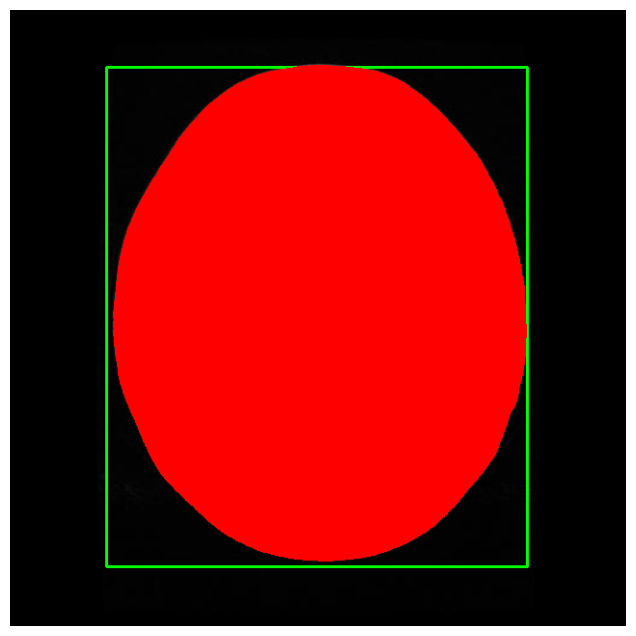

In [4]:
# Step 10: Visualization Function
def visualize_detection_and_segmentation(image_tensor, boxes, masks):
    img = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8).copy()

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    for mask in masks:
        mask = mask.squeeze()
        img[mask > 0.5] = [255, 0, 0]

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# Step 11: Full Pipeline Example
for images, filenames in test_loader:
    for idx in range(images.size(0)):
        image = images[idx]

        # 1. Detect tumor with YOLO
        yolo_results = detect_with_yolo(image)

        boxes = []
        for result in yolo_results:
            if len(result.boxes) > 0:
                for box in result.boxes.xyxy:
                    boxes.append(box.cpu().numpy())

        # 2. Segment tumor with SAM2
        all_masks = []
        for box in boxes:
            masks = segment_tumor(image, box)
            all_masks.extend(masks)

        # 3. Visualize
        visualize_detection_and_segmentation(image, boxes, all_masks)

        break  # Remove break to run on full batch
    break